# Why So Harsh - Multi-label NLP Classification

**Importing necessary Libraries**

In [ ]:
import numpy as np
import random
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE
from collections import Counter
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer
import string
from sklearn.utils import shuffle
nltk.download('all')
nltk.download('punkt')

fig_dims = (10,7)

[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /root/nltk_data...
[nltk_data]    |   Package abc is already up-to-date!
[nltk_data]    | Downloading package alpino to /root/nltk_data...
[nltk_data]    |   Package alpino is already up-to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger is already up-
[nltk_data]    |       to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger_ru to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger_ru is already
[nltk_data]    |       up-to-date!
[nltk_data]    | Downloading package basque_grammars to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Package basque_grammars is already up-to-date!
[nltk_data]    | Downloading package bcp47 to /root/nltk_data...
[nltk_data]    |   Package bcp47 is already up-to-dat

**Importing libraries for pre-processing sentences**

In [ ]:
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords

**Opening the csv files as dataframes**

In [ ]:
train_url = "https://raw.githubusercontent.com/ishaanj0412/Why_so_harsh/main/train.csv"
test_url = "https://raw.githubusercontent.com/ishaanj0412/Why_so_harsh/main/test.csv"
sample_url = "https://raw.githubusercontent.com/ishaanj0412/Why_so_harsh/main/sample.csv"
train_df = pd.read_csv(train_url).fillna(' ')
test_df = pd.read_csv(test_url).fillna(' ')

In [ ]:
train_df

,id,text,harsh,extremely_harsh,vulgar,threatening,disrespect,targeted_hate
0,a8be7c5d4527adbbf15f,""", 6 December 2007 (UTC)\nI am interested, not...",0,0,0,0,0,0
1,0b7ca73f388222aad64d,I added about three missing parameters to temp...,0,0,0,0,0,0
2,db934381501872ba6f38,SANDBOX?? \n\nI DID YOUR MADRE DID IN THE SANDBOX,1,0,0,0,0,0
3,228015c4a87c4b1f09a7,"why good sir? Why? \n\nYou, sir, obviously do ...",1,0,1,1,1,0
4,b18f26cfa1408b52e949,"""\n\n Source \n\nIncase I forget, or someone e...",0,0,0,0,0,0
...,...,...,...,...,...,...,...,...
89354,748a13233c1ea91c4584,", this is becuase very few of his critics have...",0,0,0,0,0,0
89355,e49b832cc766ee220113,"""\nIf you're going to be technical, Boyd never...",0,0,0,0,0,0
89356,ff4751b348157ac2b585,"""\n\n Join us at FB \nHello Pakistanis Wikiped...",0,0,0,0,0,0
89357,94a3215b11a49ba57d61,Lockhart \n\nI updated some of the references ...,0,0,0,0,0,0


## Exploratory Data Analysis

### Checking for data imbalance

Number of comments with 1:
 harsh              9.578218
extremely_harsh    1.026198
vulgar             5.306684
threatening        0.299914
disrespect         4.915006
targeted_hate      0.897503
dtype: float64
Number of comments with 0:
 harsh              90.421782
extremely_harsh    98.973802
vulgar             94.693316
threatening        99.700086
disrespect         95.084994
targeted_hate      99.102497
dtype: float64


<Figure size 720x504 with 0 Axes>

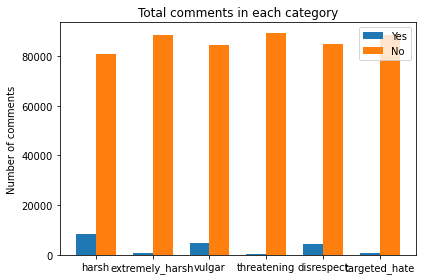

In [ ]:
plt.figure(figsize=fig_dims)
labels = train_df.columns[2:]
width = 0.35
x = np.arange(len(labels))

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, train_df.iloc[:, 2:].sum(), width, label='Yes')
print('Number of comments with 1:\n', train_df.iloc[:, 2:].sum()/len(train_df)*100)
rects2 = ax.bar(x + width/2, len(train_df) - train_df.iloc[:, 2:].sum(), width, label='No')
print('Number of comments with 0:\n', (1 - train_df.iloc[:, 2:].sum()/len(train_df))*100)

ax.set_ylabel('Number of comments')
ax.set_title('Total comments in each category')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

fig.tight_layout()

plt.show()

### SMOTE algorithm for Over-sampling minority classes

In [ ]:
rslt_df = train_df[(train_df['harsh']==0) | (train_df['extremely_harsh']==0) | (train_df['vulgar']==0) |(train_df['threatening']==0) | (train_df['disrespect']==0) | (train_df['targeted_hate']==0)]
rslt_df2 = train_df[(train_df['harsh']==0) | (train_df['extremely_harsh']==0) | (train_df['vulgar']==0) |(train_df['threatening']==1) | (train_df['disrespect']==0) | (train_df['targeted_hate']==0)]

In [ ]:
new1 = rslt_df[['id', 'text', 'threatening']].copy() 
new2 = rslt_df2[['id', 'text', 'threatening']].copy()
new = pd.concat([new1, new2], ignore_index=True)

newxtrain = new['text']
newytrain = new['threatening']

In [ ]:
new_vect = TfidfVectorizer(ngram_range=(1, 2), max_df=0.95, min_df=5)

X1 = new_vect.fit_transform(newxtrain)

In [ ]:
print('Original dataset shape %s' % Counter(newytrain))
sm = SMOTE(random_state=12)
x_train_res, y_train_res = sm.fit_resample(X1, newytrain)
print('Resampled dataset shape %s' % Counter(y_train_res))

Original dataset shape Counter({0: 178026, 1: 516})
Resampled dataset shape Counter({0: 178026, 1: 178026})


**As seen the minority label *threatening* was oversampled. In a similar way, all minority classes can be oversampled to remove the bias in the dataset.** 

Since this is a multilabelled dataset it requires the use of the MLSMOTE algorithm to oversample based on all labels.

### Further EDA

Text(0.5, 0, 'Types of comments')

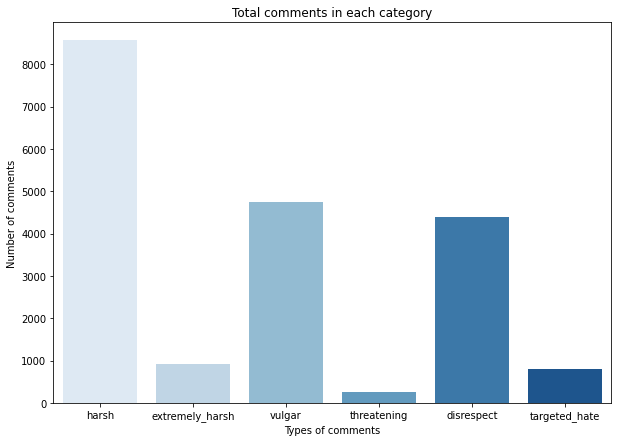

In [ ]:
plt.figure(figsize=fig_dims)
sns.barplot(x = train_df.columns[2:8], y = train_df.iloc[:, 2:8].sum(), palette = 'Blues')
plt.title('Total comments in each category')
plt.ylabel('Number of comments')
plt.xlabel('Types of comments')

**Word cloud to display all important words in the corpus**

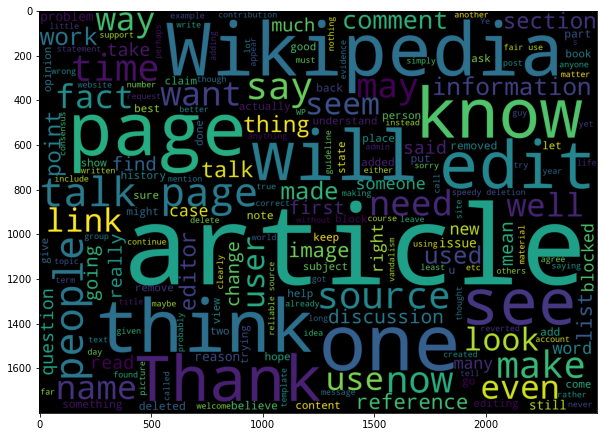

In [ ]:
from wordcloud import WordCloud, STOPWORDS

plt.figure(figsize=(10,8))
wc1_text = train_df.text.values
wc2_text = train_df[(train_df['harsh']==1) | (train_df['extremely_harsh']==1) | (train_df['vulgar']==1) |(train_df['threatening']==1) | (train_df['disrespect']==1) | (train_df['targeted_hate']==1)]
wc2_text = wc2_text.text.values

cloud1 = WordCloud(stopwords=STOPWORDS,
                  background_color='black',
                  width=2500,
                  height=1800).generate(''.join(wc1_text))

cloud2 = WordCloud(stopwords=STOPWORDS,
                  background_color='black',
                  width=2500,
                  height=1800).generate(''.join(wc2_text))
plt.imshow(cloud1)

The wordcloud displayed above shows that most comments are not harsh and regarding articles, forums and pages i.e., relevant.

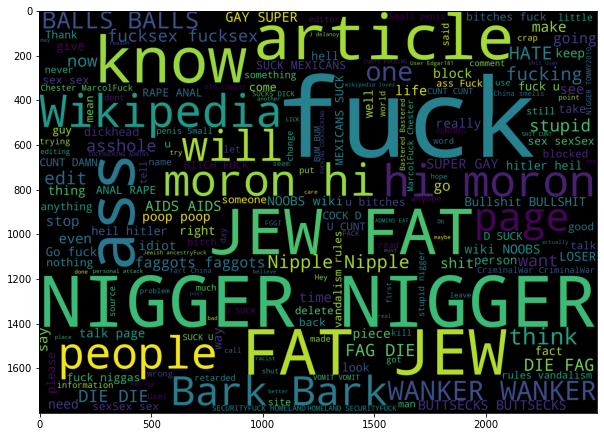

In [ ]:
plt.figure(figsize=(10,8))
plt.imshow(cloud2)

In [ ]:
count_ml = 0
count = 0
for i in range(len(train_df)):
    n = train_df.iloc[i,2:].sum()
    count+=1
    if n > 1:
        count_ml+=1

print('Total comments:', count, '; Total multi-labeled comments', count_ml)

Total comments: 89359 ; Total multi-labeled comments 5539


Above count also shows how unbalanced the data is.

In [ ]:
X = train_df['text'].copy(deep=True)
test_X = test_df['text'].copy(deep=True)
all_text = pd.concat([X, test_X])

### Pre-processing using lemmatization and removal of stopwords

In [ ]:
categories = ['harsh', 'extremely_harsh', 'vulgar', 'threatening', 'disrespect', 'targeted_hate']

**Cleaning up text**

In [ ]:
import re

In [ ]:
def clean_text(text):
    # text = text.lower()
    url = re.compile(r'https?://\S+|www\.\S+')
    text =  url.sub(r'', text)

    html = re.compile(r'<.*?>')
    text = html.sub(r'', text)

    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags = re.UNICODE)
    text = emoji_pattern.sub(r'', text)

    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"What's", "What is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "cannot ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"I'm", "I am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r"\'scuse", " excuse ", text)
    text = re.sub('\W', ' ', text)
    text = re.sub('\s+', ' ', text)
    text = text.strip(' ')

    text = re.sub('[^a-zA-Z]', ' ', text)
    text = re.sub(r"\s+[a-zA-Z]\s+", ' ', text)

    text = re.sub(r"\d{1,3}\.\d{1,3}\.\d{1,3}\.\d{1,3}","", text)

    return text

In [ ]:
train_df['text'] = train_df['text'].map(lambda com : clean_text(com))
test_df['text'] = test_df['text'].map(lambda com : clean_text(com))

**Text before lemmatization and removal of stopwords**

In [ ]:
train_df["text"][2]

'SANDBOX DID YOUR MADRE DID IN THE SANDBOX'

**Lemmatization**

In [ ]:
lemmatizer = WordNetLemmatizer()
tokenizer = nltk.tokenize.WhitespaceTokenizer()
eng_stopwords = stopwords.words('english')

In [ ]:
def lemmatize_string(text, stopwords):
  return [lemmatizer.lemmatize(word) for word in tokenizer.tokenize(text) if (word.lower() not in set(stopwords) and word.lower().isalpha())]

In [ ]:
train_data = train_df["text"]
test_data = test_df["text"]
train_data = train_data.apply(lemmatize_string, stopwords = eng_stopwords)
test_data = test_data.apply(lemmatize_string, stopwords = eng_stopwords)
train_data = train_data.apply(lambda x: ' '.join(([word for word in x])))
test_data = test_data.apply(lambda x: ' '.join((word for word in x)))
train_df["text"] = train_data
test_df["text"] = test_data
del train_data, test_data

**Text after lemmatization**

In [ ]:
train_df["text"][2]

'SANDBOX MADRE SANDBOX'

In [ ]:
X_train = train_df['text'].copy(deep=True)
X_test = test_df['text'].copy(deep=True)

## Training Models

**Word vectorization of text using TFIDF vectorizer**

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import make_union

word_vectorizer = TfidfVectorizer(
    sublinear_tf=True,
    strip_accents='unicode',
    analyzer='word',
    token_pattern=r'\w{1,}',
    ngram_range=(1, 2),
    max_features=30000)

char_vectorizer = TfidfVectorizer(
    sublinear_tf=True,
    strip_accents='unicode',
    analyzer='char',
    ngram_range=(1, 4),
    max_features=30000)
vect = make_union(word_vectorizer, char_vectorizer, n_jobs=2)

vect

FeatureUnion(n_jobs=2,
             transformer_list=[('tfidfvectorizer-1',
                                TfidfVectorizer(max_features=30000,
                                                ngram_range=(1, 2),
                                                strip_accents='unicode',
                                                sublinear_tf=True,
                                                token_pattern='\\w{1,}')),
                               ('tfidfvectorizer-2',
                                TfidfVectorizer(analyzer='char',
                                                max_features=30000,
                                                ngram_range=(1, 4),
                                                strip_accents='unicode',
                                                sublinear_tf=True))])

In [ ]:
vect.fit(all_text)
X_dtm = vect.transform(X)
test_X_dtm = vect.transform(test_X)

In [ ]:
X_train_dtm = vect.transform(X_train)
X_test_dtm = vect.transform(X_test)

### Using Glove vector embeddings

In [ ]:
# !wget http://nlp.stanford.edu/data/glove.6B.zip
# !unzip glove*.zip

In [ ]:
# embeddings_dictionary = dict()
word2vec = dict()
embedding = []
idx2word = []
glove_file = open('glove.6B.100d.txt', encoding="utf8")

for line in glove_file:

    values = line.split()
    word = values[0]
    vec = np.asarray(values[1:], dtype='float32')
    word2vec[word] = vec
    embedding.append(vec)
    idx2word.append(word)
print('Found %s word vectors.' % len(word2vec))
embedding = np.array(embedding)
V, D = embedding.shape
glove_file.close()



Found 400000 word vectors.


In [ ]:
def glove_transform(data):
  X = np.zeros((len(data), D))
  n = 0
  emptycount = 0
  for text in data:
    tokens = text.lower().split()
    vecs = []
    for word in tokens:
      if word in word2vec:
        vec = word2vec[word]
        vecs.append(vec)
    if len(vecs) > 0:
      vecs = np.array(vecs)
      X[n] = vecs.mean(axis=0)
    else:
      emptycount += 1
    n += 1
  print("Number of samples with no words found: %s / %s" % (emptycount, len(data)))
  return X

**Importing necessary libraries for models**

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.multiclass import OneVsRestClassifier
import math

### Logistic Regression and Naive Bayes models using GloVe vectors

In [ ]:
Xtrain = glove_transform(X)

param_grid={"C" : np.logspace(-3,3,7), "penalty" : ["l1","l2"]}       # l1 lasso l2 ridge

log_reg = LogisticRegression(solver='sag', max_iter = 1000)

logreg_cv = GridSearchCV(log_reg, param_grid, cv = 10)          # Using gridsearch for hyperparameter tuning takes a very long time so it is not feasible to be used here

Xtest = glove_transform(test_X)

scores = []
sample_df3 = pd.DataFrame.from_dict({'id': test_df['id']})
for label in categories:
    print('... Processing {}'.format(label))
    y = train_df[label]
    # train the model using X_dtm & y
    cv_score = np.mean(cross_val_score(
        log_reg, Xtrain, y, cv=3, scoring='roc_auc'))
    scores.append(cv_score)
    print('CV score for class {} is {}'.format(label, cv_score))

    # train the model using X_dtm & y
    log_reg.fit(Xtrain, y)
    # compute the predicted probabilities for X_test_dtm
    test_y_prob = log_reg.predict_proba(Xtest)[:,1]
    sample_df3[label] = test_y_prob
print('Total CV score is {}'.format(np.mean(scores)))


Number of samples with no words found: 125 / 89359
Number of samples with no words found: 46 / 38297
... Processing harsh
CV score for class harsh is 0.9054202497591816
... Processing extremely_harsh
CV score for class extremely_harsh is 0.9626221305916749
... Processing vulgar
CV score for class vulgar is 0.9187742722575623
... Processing threatening
CV score for class threatening is 0.9590307920792065
... Processing disrespect
CV score for class disrespect is 0.9237605985185247
... Processing targeted_hate
CV score for class targeted_hate is 0.9341802913823855
Total CV score is 0.9339647224314226


In [ ]:
m_nb = MultinomialNB()

scores = []
sample_df5 = pd.DataFrame.from_dict({'id': test_df['id']})
for label in categories:
    print('... Processing {}'.format(label))
    y = train_df[label]
    # train the model using X_dtm & y
    cv_score = np.mean(cross_val_score(
        m_nb, abs(Xtrain), y, cv=3, scoring='roc_auc'))
    scores.append(cv_score)
    print('CV score for class {} is {}'.format(label, cv_score))

    # train the model using X_dtm & y
    m_nb.fit(abs(Xtrain), y)
    # compute the predicted probabilities for X_test_dtm
    test_y_prob = m_nb.predict_proba(Xtest)[:,1]
    sample_df5[label] = test_y_prob
print('Total CV score is {}'.format(np.mean(scores)))

... Processing harsh
CV score for class harsh is 0.8026437807272501
... Processing extremely_harsh
CV score for class extremely_harsh is 0.9139333223973912
... Processing vulgar
CV score for class vulgar is 0.8332953059227575
... Processing threatening
CV score for class threatening is 0.904074290155792
... Processing disrespect
CV score for class disrespect is 0.8360731314030864
... Processing targeted_hate
CV score for class targeted_hate is 0.8342010162777992
Total CV score is 0.8540368078140127


### Logistic Regression and Naive Bayes models using TF-IDF

**Logistic Regression Model**

In [ ]:
logreg = LogisticRegression(solver='sag', max_iter=100)

scores = []
sample_df = pd.DataFrame.from_dict({'id': test_df['id']})
train_output = pd.DataFrame.from_dict({'id': train_df['id']})
for label in categories:
    print('... Processing {}'.format(label))
    y = train_df[label]
    # train the model using X_dtm & y
    cv_score = np.mean(cross_val_score(
        logreg, X_dtm, y, cv=3, scoring='roc_auc'))
    scores.append(cv_score)
    print('CV score for class {} is {}'.format(label, cv_score))

    # train the model using X_dtm & y
    logreg.fit(X_dtm, y)

    train_y_prob = logreg.predict_proba(X_dtm)[:,1]
    train_output[label] = train_y_prob
    # compute the predicted probabilities for X_test_dtm
    test_y_prob = logreg.predict_proba(test_X_dtm)[:,1]
    sample_df[label] = test_y_prob
print('Total CV score is {}'.format(np.mean(scores)))

... Processing harsh
CV score for class harsh is 0.9757088305331457
... Processing extremely_harsh
CV score for class extremely_harsh is 0.9876174153118024
... Processing vulgar
CV score for class vulgar is 0.9885424313263026
... Processing threatening
CV score for class threatening is 0.9891782274939995
... Processing disrespect
CV score for class disrespect is 0.9810333126976144
... Processing targeted_hate
CV score for class targeted_hate is 0.9802198816762323
Total CV score is 0.9837166831731828


**Multinomial Naive Bayes Model**

In [ ]:
mnb = MultinomialNB()

scores = []
sample_df2 = pd.DataFrame.from_dict({'id': test_df['id']})
for label in categories:
    print('... Processing {}'.format(label))
    y = train_df[label]
    # compute the training accuracy
    cv_score = np.mean(cross_val_score(
        mnb, X_dtm, y, cv=3, scoring='roc_auc'))
    scores.append(cv_score)
    print('CV score for class {} is {}'.format(label, cv_score))

    # train the model using X_dtm & y
    mnb.fit(X_dtm, y)
    # compute the predicted probabilities for X_test_dtm
    test_y_prob = mnb.predict_proba(test_X_dtm)[:,1]
    sample_df2[label] = test_y_prob

print('Total CV score is {}'.format(np.mean(scores)))

... Processing harsh
CV score for class harsh is 0.9448655280748168
... Processing extremely_harsh
CV score for class extremely_harsh is 0.9336419167226823
... Processing vulgar
CV score for class vulgar is 0.9434118231388852
... Processing threatening
CV score for class threatening is 0.8028074781538511
... Processing disrespect
CV score for class disrespect is 0.9408091452181836
... Processing targeted_hate
CV score for class targeted_hate is 0.8550603143957981
Total CV score is 0.9034327009507029


### Ensembles



Logistic Regression with Gradient Boosting

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
from scipy import sparse

rfc = GradientBoostingClassifier(n_estimators = 200, max_depth = 50, min_samples_leaf = 3)

scores = []
sample_df4 = pd.DataFrame.from_dict({'id': test_df['id']})
for label in categories:
    print('... Processing {}'.format(label))
    y = train_df[label]
    # compute the training accuracy
    # cv_score = np.mean(cross_val_score(
    #     rfc, X_train_dtm, y, cv=3, scoring='roc_auc'))
    # scores.append(cv_score)
    # print('CV score for class {} is {}'.format(label, cv_score))
    temp_x = sparse.hstack((X_dtm,np.array(train_output[label])[:,None])).A
    # train the model using X_dtm & y
    rfc.fit(X_dtm, y)
    val_y_prob = rfc.predict_proba(temp_x)[:,1]
    print('ROC AUC score for class {} is {}'.format(label, roc_auc_score(y, val_y_prob)))
    # compute the predicted probabilities for X_test_dtm
    test_X_dtm = sparse.hstack((test_X_dtm,np.array(sample_df[label])[:,None])).A
    test_y_prob = rfc.predict_proba(test_X_dtm)[:,1]
    sample_df4[label] = test_y_prob

# print('Total CV score is {}'.format(np.mean(scores)))

... Processing harsh


**Adding the predicted results into a csv file**

In [ ]:
sample_df.to_csv('sample.csv', index=False)
sample_df2.to_csv('sample2.csv', index=False)
sample_df3.to_csv('sample3.csv', index=False)
sample_df4.to_csv('sample4.csv', index=False)
sample_df5.to_csv('sample5.csv', index=False)

In [ ]:
sample_df

In [ ]:
sample_df2

In [ ]:
sample_df3